Running RSI backtest strategy...

BACKTEST RESULTS
Initial Capital: 10000
Final Value: $10,271.01
Total Return (%): 2.71
Buy & Hold Return (%): 3.72
Number of Trades: 12
Win Rate (%): 83.33

TRADES EXECUTED
               Date Type   Price   Shares       RSI     Profit
2025-09-24 09:00:00  BUY 6711.50 1.489980 26.213592        NaN
2025-09-29 10:00:00 SELL 6711.00 1.489980 71.656977  -0.744990
2025-10-10 10:00:00  BUY 6682.75 1.496278 21.674877        NaN
2025-10-14 13:00:00 SELL 6713.00 1.496278 70.588235  44.517434
2025-10-16 14:00:00  BUY 6668.50 1.506263 26.911765        NaN
2025-10-20 09:00:00 SELL 6773.00 1.506263 72.039943 201.921959
2025-10-22 12:00:00  BUY 6705.25 1.521483 25.045704        NaN
2025-10-24 08:30:00 SELL 6829.50 1.521483 71.677852 390.966186
2025-10-30 14:00:00  BUY 6853.75 1.516099 18.709677        NaN
2025-11-10 14:00:00 SELL 6857.25 1.516099 76.470588 396.272534
2025-11-13 09:00:00  BUY 6805.75 1.527572 29.584775        NaN
2025-11-24 12:00:00 SELL 6723.75 1.52

ValueError: x and y must be the same size

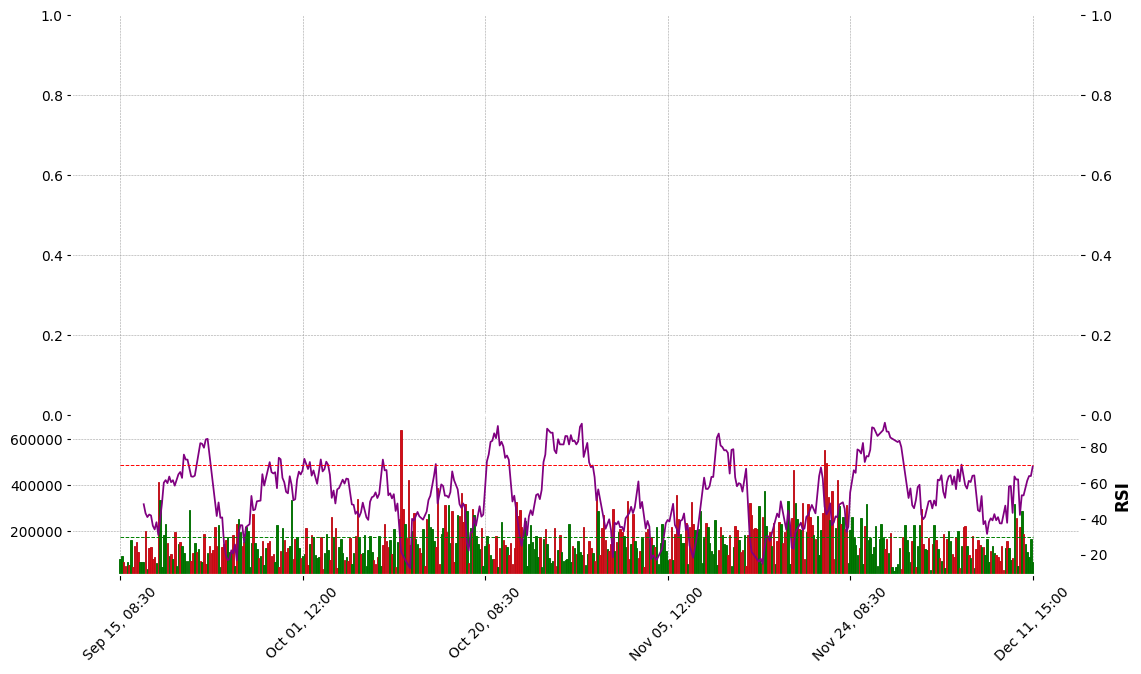

In [8]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Download stock data
def get_data(ticker, start_date, end_date):
    """Download historical stock data"""
    # data = yf.download(ticker, start=start_date, end=end_date)
    csv_file = 'ES(495512563)(1 hour)(3 M)_historical_data.csv'
    df = pd.read_csv(csv_file, parse_dates=True)
    # df.columns = df.columns.str.lower()
    df.index = pd.DatetimeIndex(df['Date'])
    return df

# Calculate RSI
def calculate_rsi(data, period=14):
    """Calculate Relative Strength Index"""
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Backtesting strategy
def backtest_rsi_strategy(data, rsi_oversold=30, rsi_overbought=70, initial_capital=10000):
    """
    Backtest RSI strategy:
    - Buy when RSI < oversold threshold
    - Sell when RSI > overbought threshold
    """
    df = data.copy()
    df['RSI'] = calculate_rsi(df)
    
    # Initialize variables
    position = 0  # 0 = no position, 1 = holding
    shares = 0
    cash = initial_capital
    portfolio_value = []
    trades = []
    
    # Generate signals
    df['Signal'] = 0
    df.loc[df['RSI'] < rsi_oversold, 'Signal'] = 1  # Buy signal
    df.loc[df['RSI'] > rsi_overbought, 'Signal'] = -1  # Sell signal
    
    # Execute trades
    for i in range(len(df)):
        date = df.index[i]
        price = float(df['Close'].iloc[i])
        signal = int(df['Signal'].iloc[i]) if not pd.isna(df['Signal'].iloc[i]) else 0
        rsi = float(df['RSI'].iloc[i]) if not pd.isna(df['RSI'].iloc[i]) else np.nan
        
        # Buy logic
        if signal == 1 and position == 0 and not np.isnan(rsi):
            shares = cash / price
            cash = 0
            position = 1
            trades.append({
                'Date': date,
                'Type': 'BUY',
                'Price': price,
                'Shares': shares,
                'RSI': rsi
            })
        
        # Sell logic
        elif signal == -1 and position == 1 and not np.isnan(rsi):
            cash = shares * price
            trades.append({
                'Date': date,
                'Type': 'SELL',
                'Price': price,
                'Shares': shares,
                'RSI': rsi,
                'Profit': cash - initial_capital
            })
            shares = 0
            position = 0
        
        # Calculate portfolio value
        current_value = cash + (shares * price if position == 1 else 0)
        portfolio_value.append(current_value)
    
    df['Portfolio_Value'] = portfolio_value
    
    return df, trades

# Calculate performance metrics
def calculate_metrics(df, trades, initial_capital):
    """Calculate strategy performance metrics"""
    final_value = df['Portfolio_Value'].iloc[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100
    
    # Buy and hold return
    buy_hold_return = ((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]) * 100
    
    # Number of trades
    num_trades = len(trades)
    
    # Win rate
    winning_trades = [t for t in trades if t['Type'] == 'SELL' and t['Profit'] > 0]
    win_rate = (len(winning_trades) / (num_trades / 2)) * 100 if num_trades > 0 else 0
    
    metrics = {
        'Initial Capital': initial_capital,
        'Final Value': final_value,
        'Total Return (%)': total_return,
        'Buy & Hold Return (%)': buy_hold_return,
        'Number of Trades': num_trades,
        'Win Rate (%)': win_rate
    }
    
    return metrics

# Visualize with mplfinance
def plot_strategy(df, trades, ticker):
    """Plot candlestick chart with RSI and trade signals"""
    # Prepare buy/sell markers
    buy_signals = [trade for trade in trades if trade['Type'] == 'BUY']
    sell_signals = [trade for trade in trades if trade['Type'] == 'SELL']
    
    buy_dates = [trade['Date'] for trade in buy_signals]
    sell_dates = [trade['Date'] for trade in sell_signals]
    
    # Create additional plots for RSI
    apds = [
        mpf.make_addplot(df['RSI'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot([70]*len(df), panel=1, color='r', linestyle='--', width=0.7),
        mpf.make_addplot([30]*len(df), panel=1, color='g', linestyle='--', width=0.7)
    ]
    
    # Add buy/sell markers
    if buy_dates:
        buy_markers = df.loc[buy_dates, 'Close']
        apds.append(mpf.make_addplot(buy_markers, type='scatter', markersize=100, 
                                      marker='^', color='green', panel=0))
    
    if sell_dates:
        sell_markers = df.loc[sell_dates, 'Close']
        apds.append(mpf.make_addplot(sell_markers, type='scatter', markersize=100, 
                                      marker='v', color='red', panel=0))
    
    # Plot
    mpf.plot(df, type='candle', style='charles', 
             title=f'{ticker} - RSI Strategy Backtest',
             ylabel='Price ($)',
             volume=True,
             addplot=apds,
             figsize=(14, 8),
             panel_ratios=(2, 1, 1))

# Main execution
if __name__ == "__main__":
    # Parameters
    TICKER = 'AAPL'
    START_DATE = '2023-01-01'
    END_DATE = '2024-12-01'
    RSI_OVERSOLD = 30
    RSI_OVERBOUGHT = 70
    INITIAL_CAPITAL = 10000
    
    # Run backtest
    print(f"Downloading {TICKER} data...")
    data = get_data(TICKER, START_DATE, END_DATE)
    
    print("Running RSI backtest strategy...")
    df, trades = backtest_rsi_strategy(data, RSI_OVERSOLD, RSI_OVERBOUGHT, INITIAL_CAPITAL)
    
    # Calculate metrics
    metrics = calculate_metrics(df, trades, INITIAL_CAPITAL)
    
    # Print results
    print("\n" + "="*50)
    print("BACKTEST RESULTS")
    print("="*50)
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"{key}: ${value:,.2f}" if 'Capital' in key or 'Value' in key else f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
    
    print("\n" + "="*50)
    print("TRADES EXECUTED")
    print("="*50)
    trades_df = pd.DataFrame(trades)
    print(trades_df.to_string(index=False))
    
    # Plot
    print("\nGenerating visualization...")
    plot_strategy(df, trades, TICKER)
    
    # Plot portfolio value over time
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['Portfolio_Value'], label='Strategy Portfolio', linewidth=2)
    plt.plot(df.index, df['Close'] / df['Close'].iloc[0] * INITIAL_CAPITAL, 
             label='Buy & Hold', linewidth=2, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value: RSI Strategy vs Buy & Hold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()